In [1]:
import sys
import os
from csbdeep.utils import Path, normalize
import numpy as np
import matplotlib.pyplot as plt
import glob
import numpy as np
from tifffile import imread, imwrite
from Utils.helpers import WingArea, multiplot, doubleplot
from skimage.morphology import remove_small_objects
from csbdeep.utils import Path, normalize
from csbdeep.models import Config, CARE
from skimage.filters import threshold_local, threshold_mean, threshold_otsu
from scipy.ndimage.morphology import binary_fill_holes
import pandas as pd
import difflib
from skimage import transform

Using TensorFlow backend.


**Hello, You only have to change one thing in this code which is the Masterdir, here you specify the path to the directory where your images are. After that you can do Cell Run all/ Kernel restart run all from the menu above to run the code**

In [2]:
Masterdir = '/media/sancere/Newton_Volume_1/DalmiroAnalysis/UnRotated/'
LeftName = 'L'
RightName = 'R'

MaskResults = Masterdir + '/MaskResults/'
AsymmetryResults = Masterdir + '/AsymmetryResults/'
AsymmetryResultsName = 'Asymmetry'
Model_Dir ='/home/sancere/Kepler/CurieDeepLearningModels/'

UNETSegmentationModelName = 'DeepWingSegmentationModelUNET'

UnetModel = CARE(config = None, name = UNETSegmentationModelName, basedir = Model_Dir)






Loading network weights from 'weights_best.h5'.








HS_WPP_d8iTRIP_june20_02L (768, 1024, 3) L


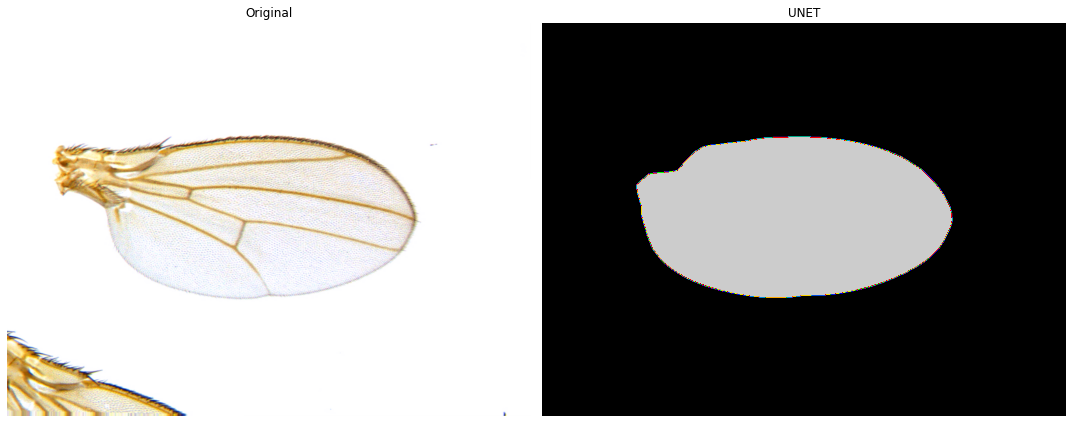

HS_WPP_d8iTRIP_june20_08L (768, 1024, 3) L


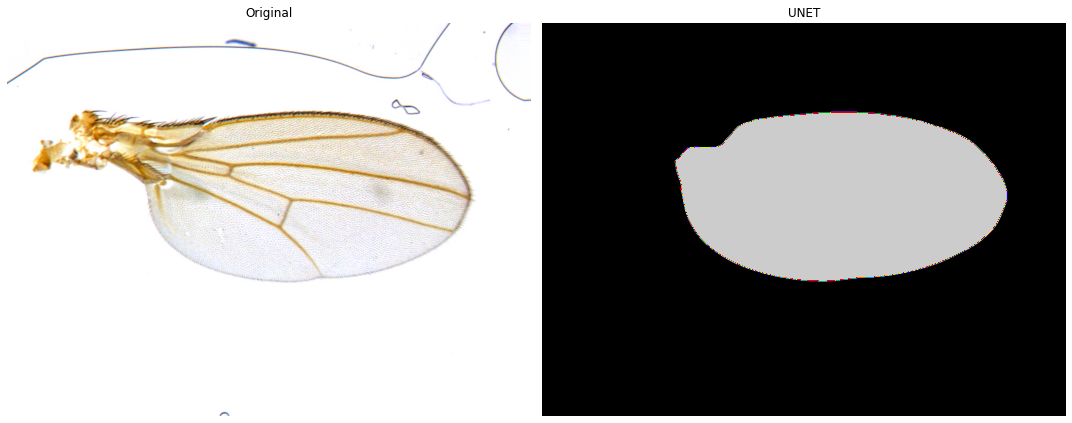

HS_WPP_d8iTRIP_june20_03L (768, 1024, 3) L


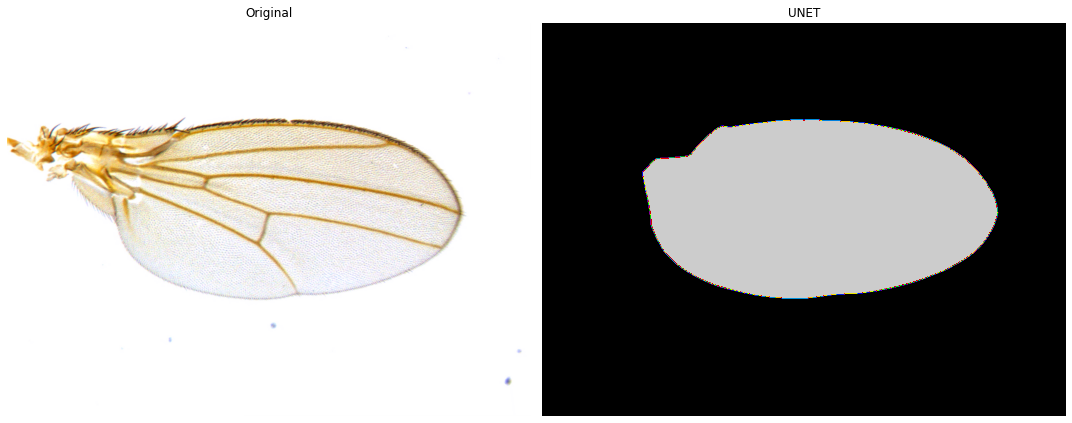

18A01.lgr3-i_v22_02L (768, 1024, 3) L


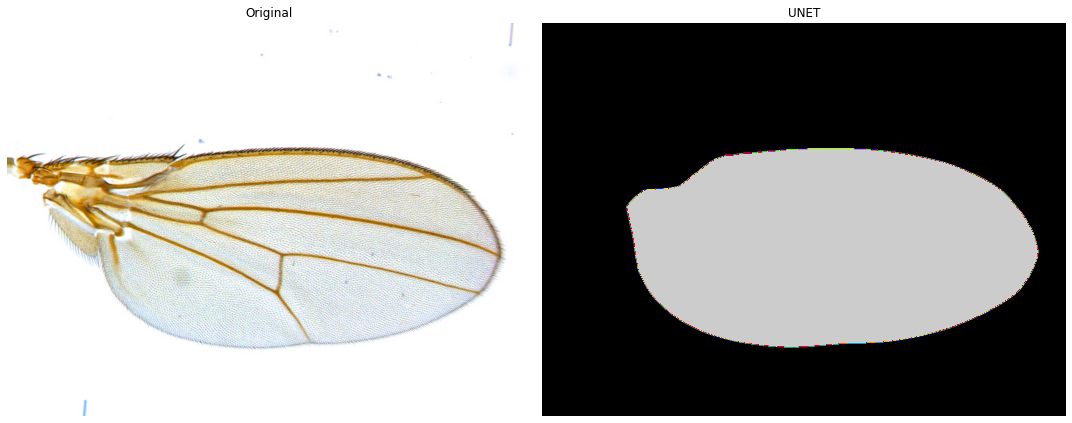

18A01.lgr3-i_v22_17L (768, 1024, 3) L


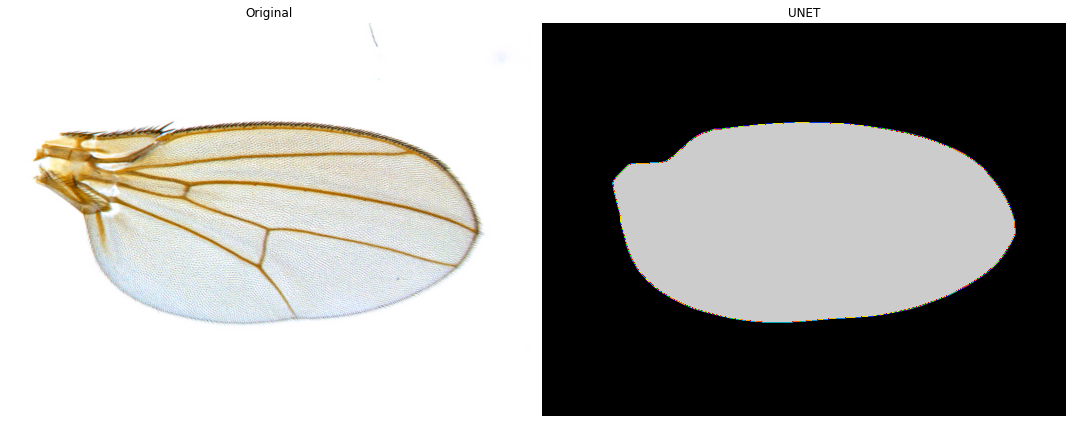

18A01.lgr3-i_v22_13L (768, 1024, 3) L


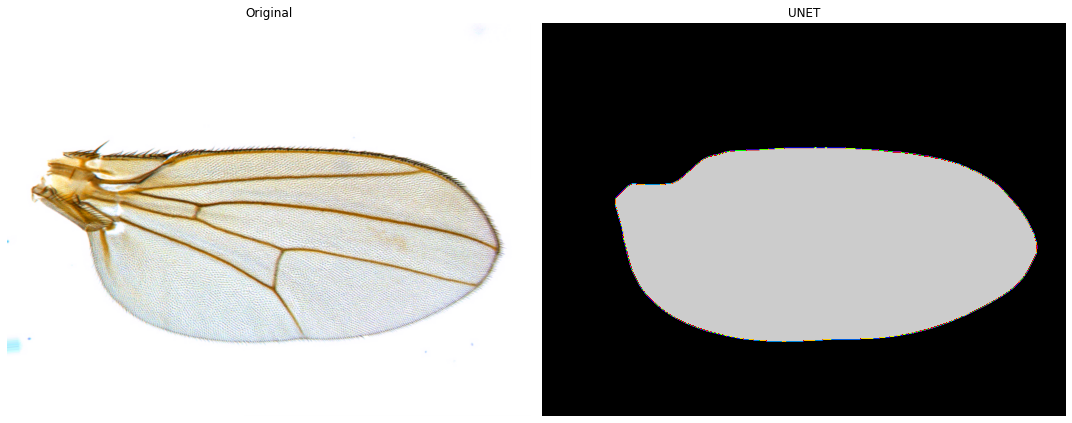

18A01.lgr3-i_v22_03L (768, 1024, 3) L


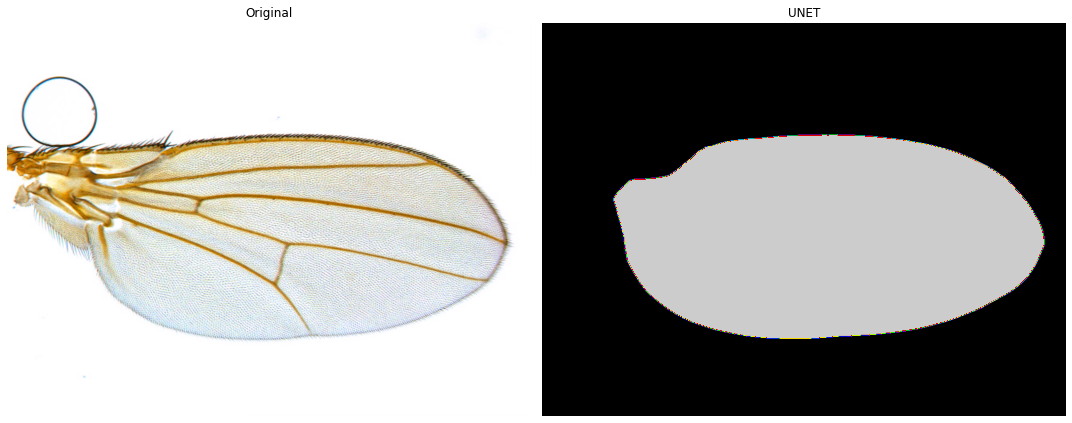

18A01.lgr3-i_v22_14L (768, 1024, 3) L


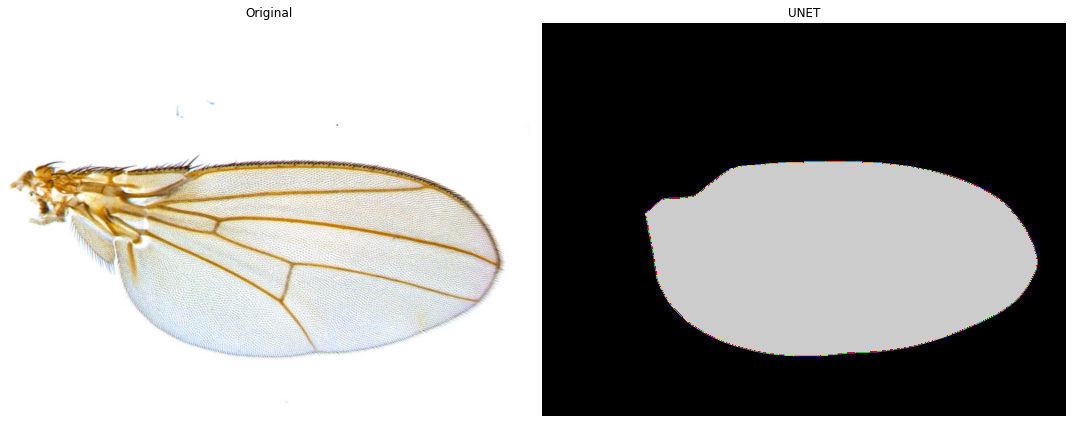

HS_WPP_d8iTRIP_june20_06L (768, 1024, 3) L


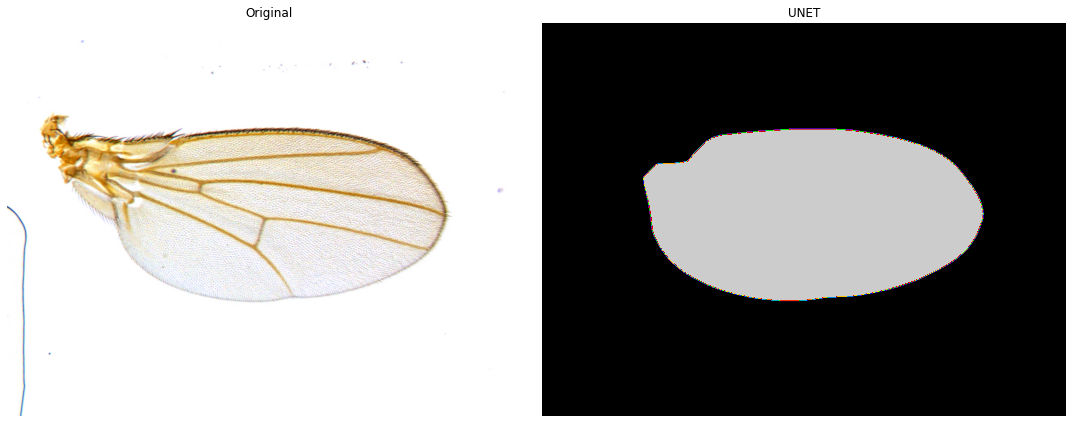

18A01.lgr3-i_v22_04L (768, 1024, 3) L


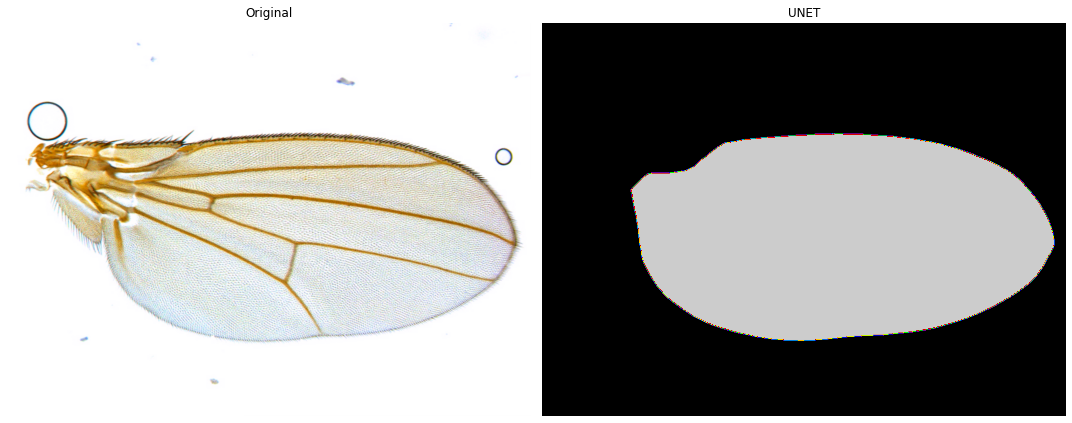

18A01.lgr3-i_v22_07L (768, 1024, 3) L


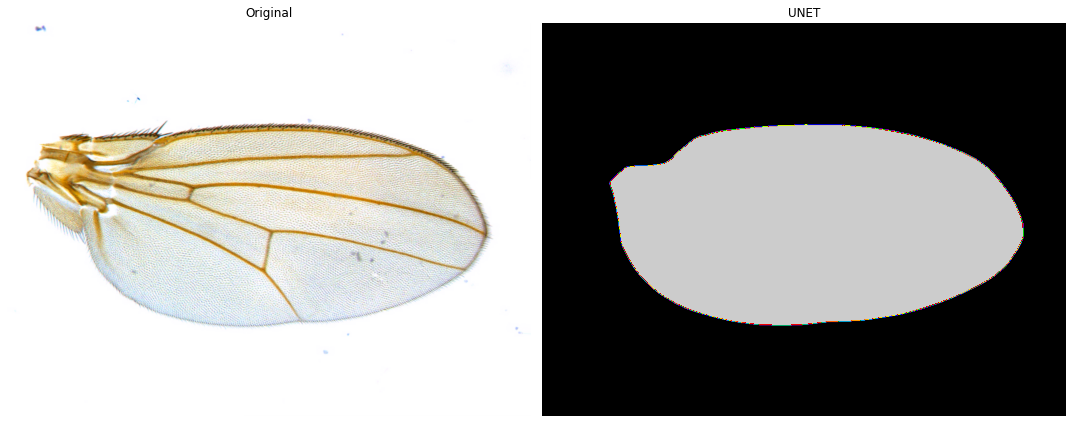

18A01.lgr3-i_v22_15L (768, 1024, 3) L


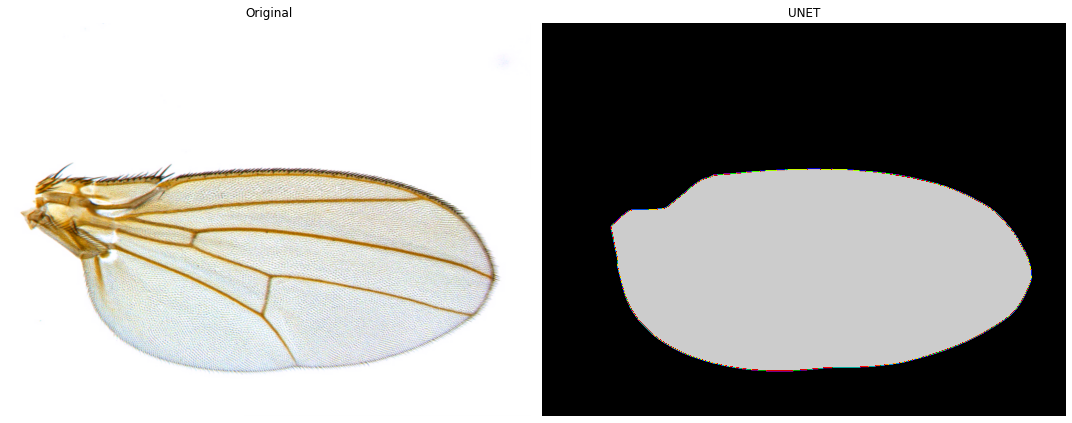

HS_WPP_d8iTRIP_june20_07L (768, 1024, 3) L


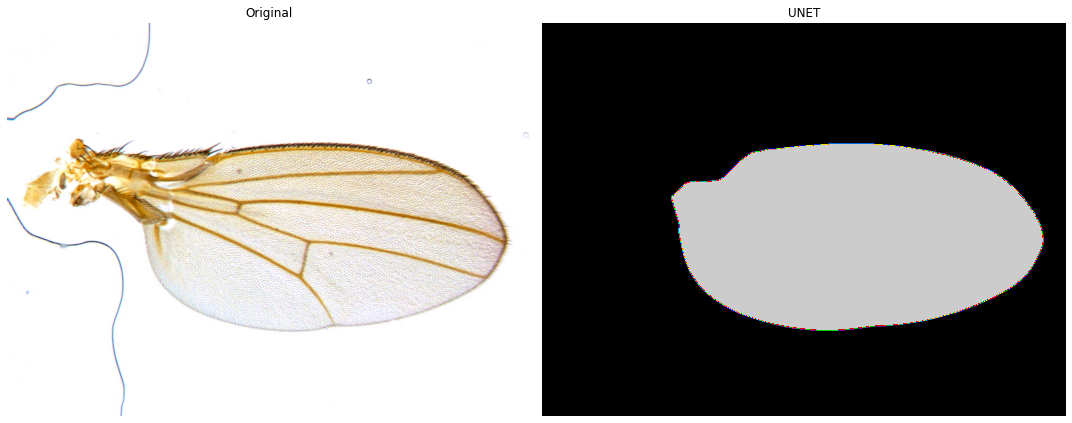

HS_WPP_d8iTRIP_june20_05L (768, 1024, 3) L


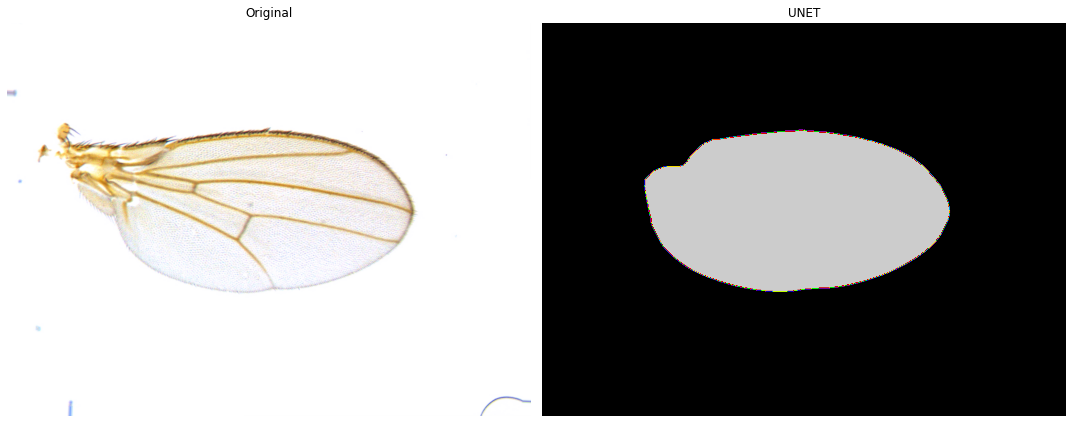

18A01.lgr3-i_v22_12L (768, 1024, 3) L


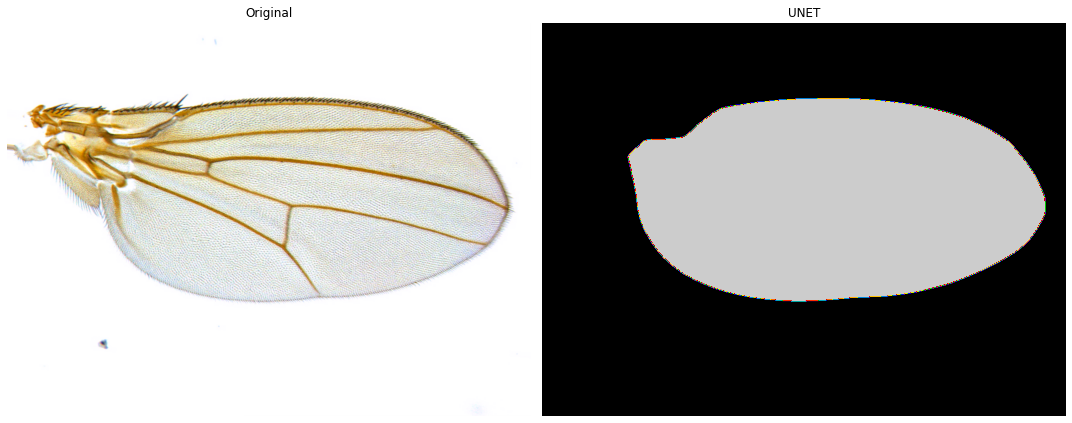

18A01.lgr3-i_v22_06L (768, 1024, 3) L


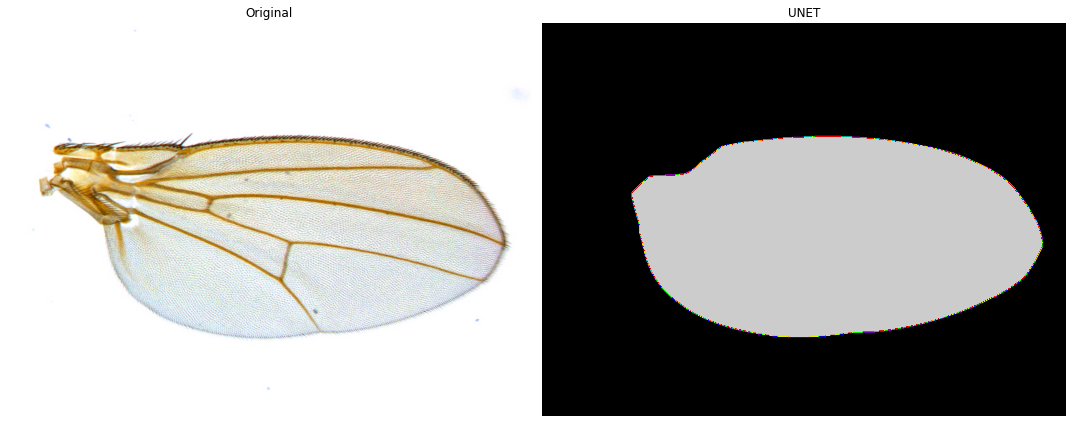

18A01.lgr3-i_v22_16L (768, 1024, 3) L


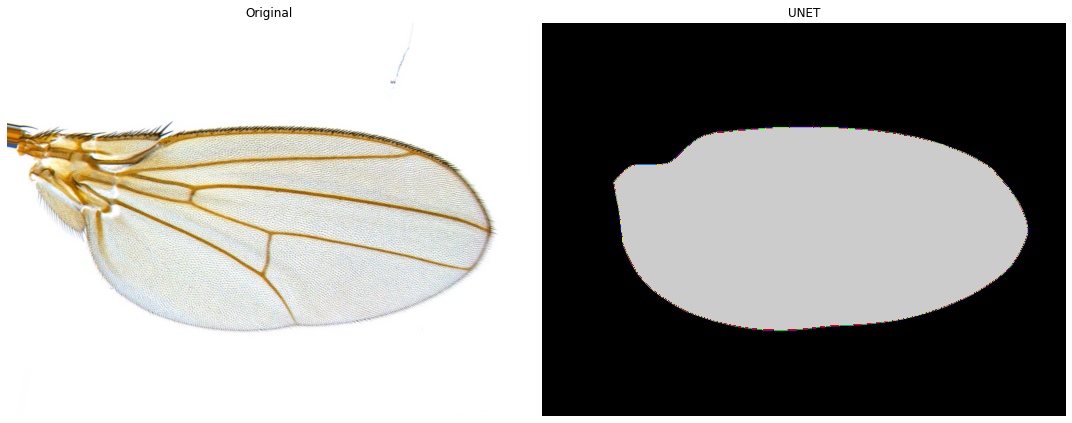

HS_WPP_d8iTRIP_june20_01L (768, 1024, 3) L


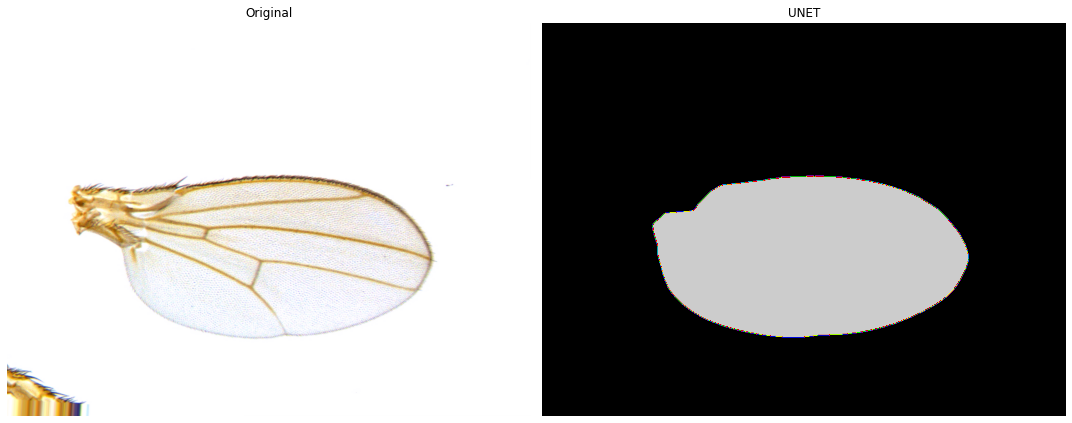

18A01.lgr3-i_v22_05L (768, 1024, 3) L


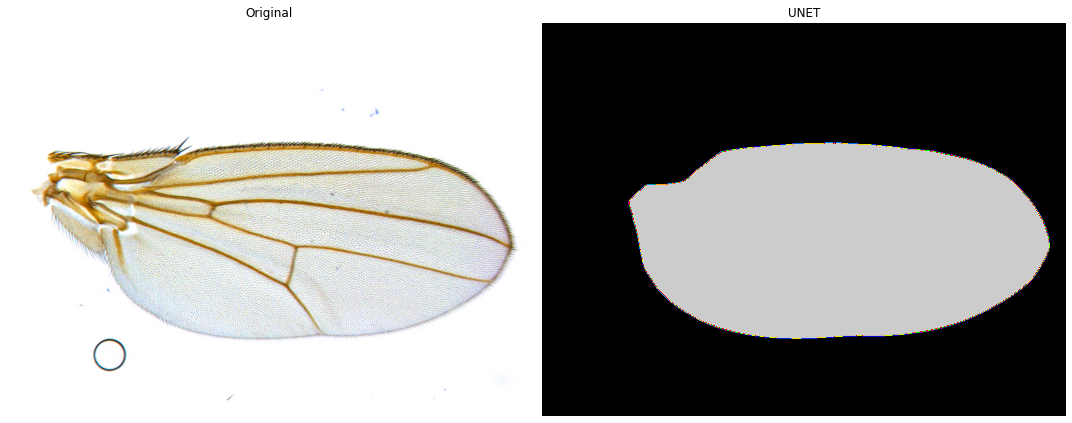

nubTS_EcI_9d@18_2d@29_L (768, 1024, 3) L


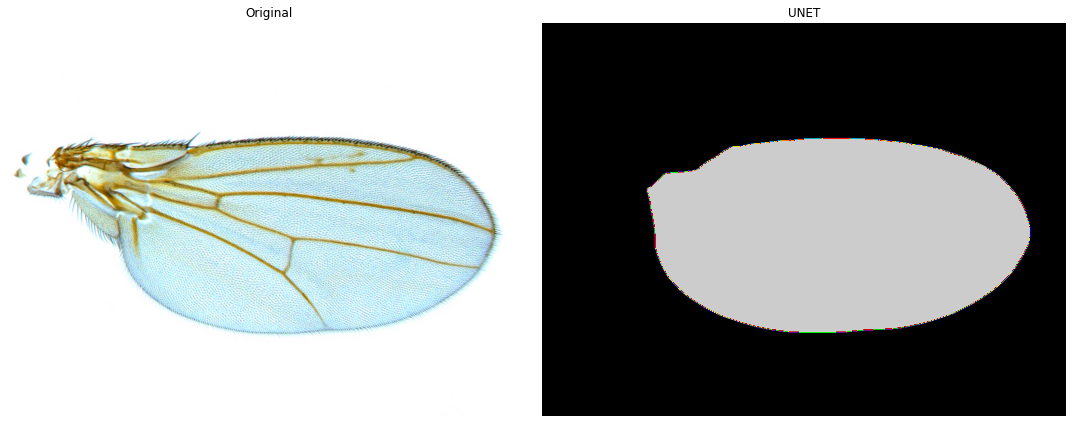

HS_WPP_d8iTRIP_june20_04L (768, 1024, 3) L


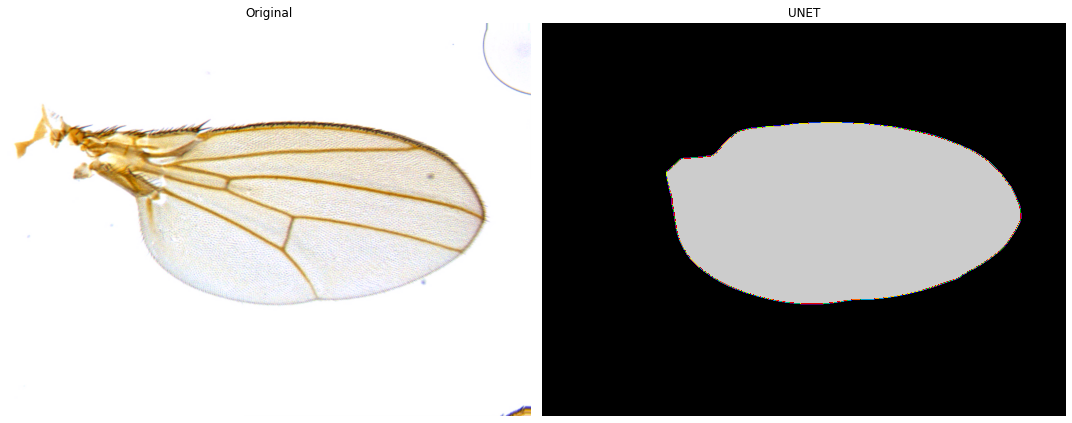

HS_WPP_d8iTRIP_june20_09L (768, 1024, 3) L


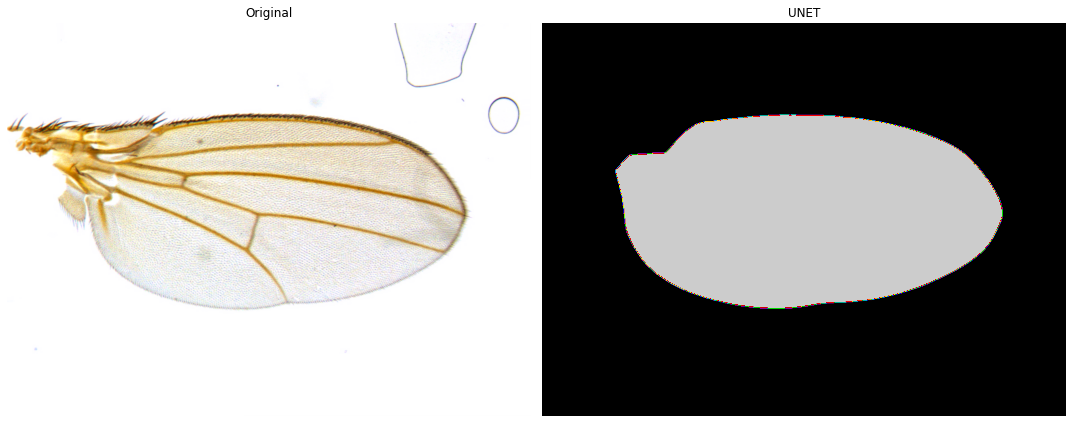

18A01.lgr3-i_v22_17R (768, 1024, 3) R


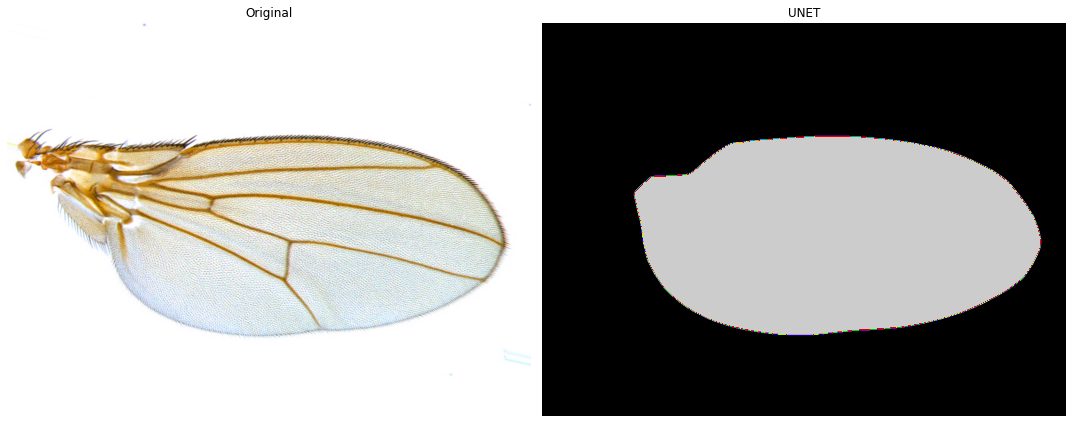

18A01.lgr3-i_v22_16R (768, 1024, 3) R


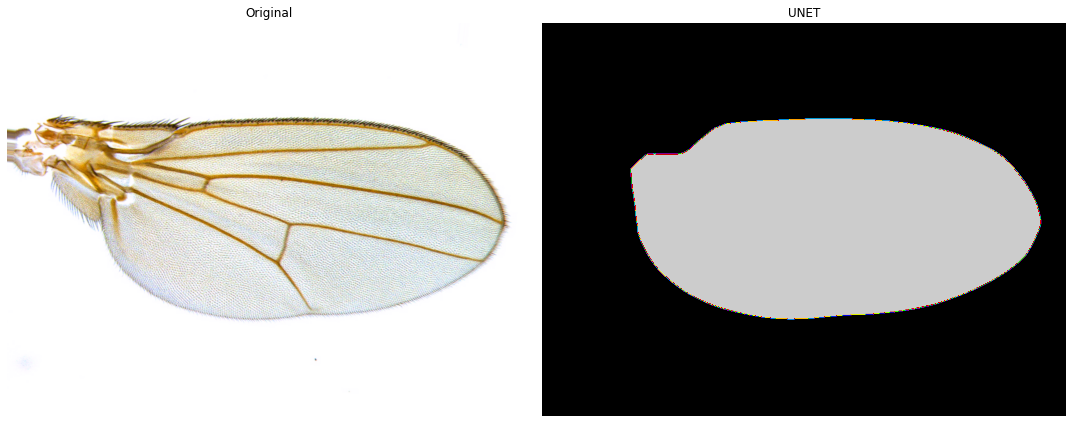

18A01.lgr3-i_v22_15R (768, 1024, 3) R


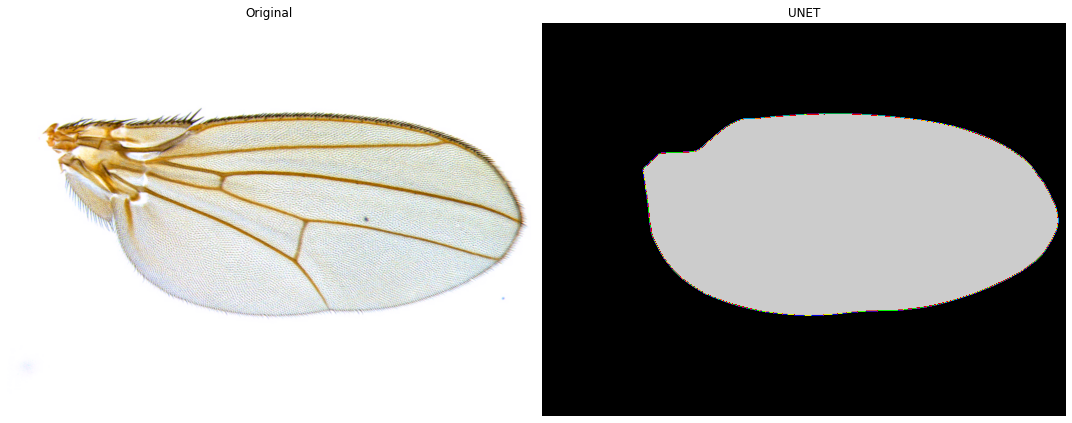

18A01.lgr3-i_v22_14R (768, 1024, 3) R


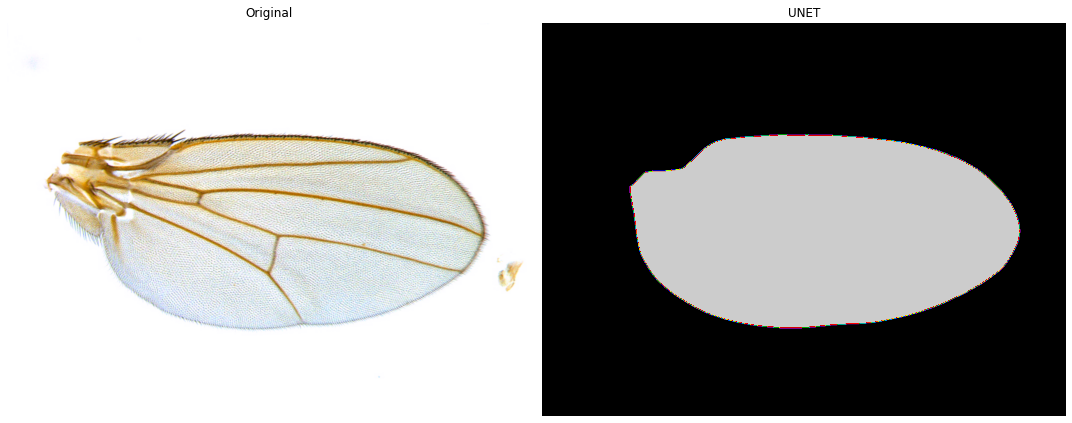

18A01.lgr3-i_v22_13R (768, 1024, 3) R


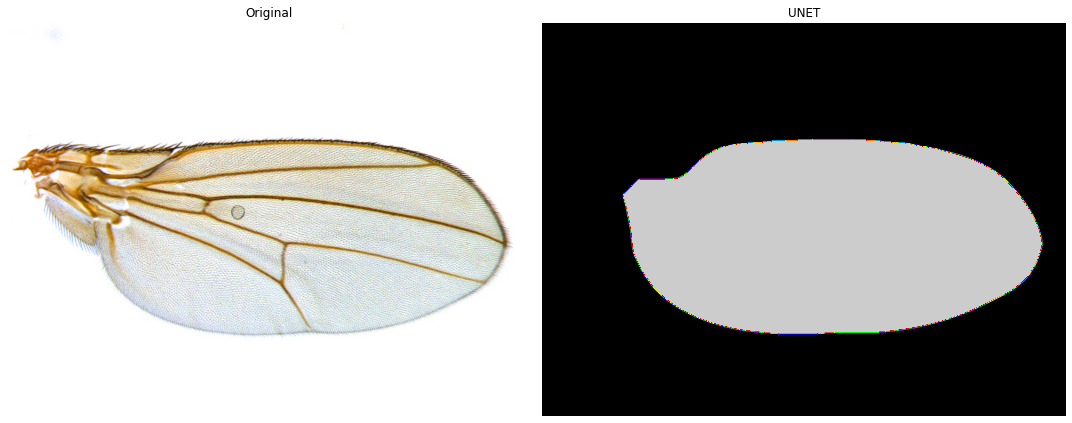

18A01.lgr3-i_v22_12R (768, 1024, 3) R


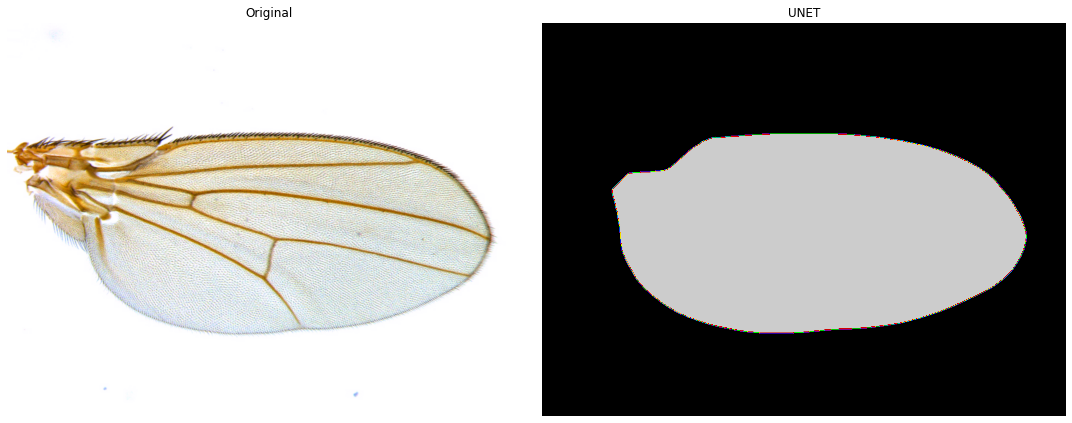

18A01.lgr3-i_v22_11R (768, 1024, 3) R


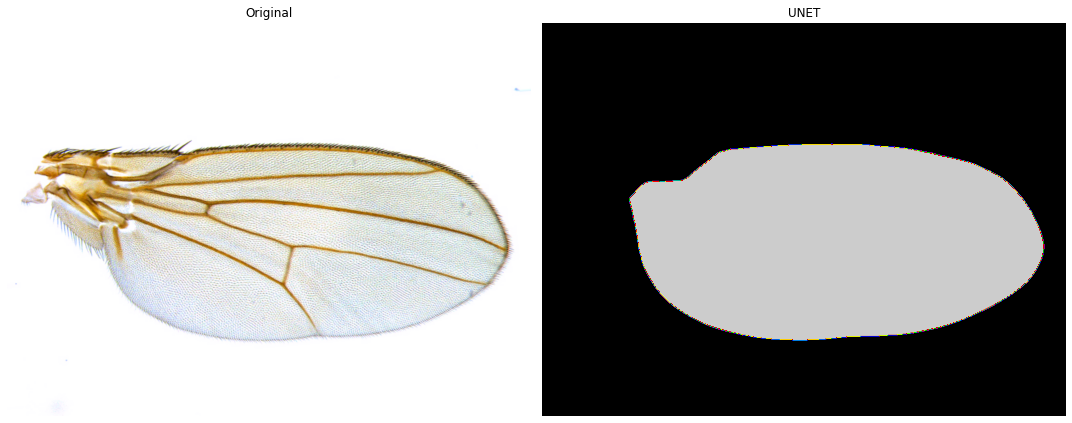

18A01.lgr3-i_v22_10R (768, 1024, 3) R


KeyboardInterrupt: 

In [9]:
#Apply the prediction on wing directory
min_size = 15000
Raw_path = os.path.join(Masterdir, '*tif')
Path(MaskResults).mkdir(exist_ok = True)
Path(AsymmetryResults).mkdir(exist_ok = True)
axes = 'YXC'
saveaxes = 'YX'
filesRaw = glob.glob(Raw_path)
filesRaw.sort
count = 0
axis_norm = (0,1,2)   # normalize channels independently

for fname in filesRaw:
            
            #Read image        
            image = imread(fname)
            
            originalX = image.shape[0]
            originalY = image.shape[1]  
            
            Name = os.path.basename(os.path.splitext(fname)[0])
      
            print(Name, image.shape, Name[-1])
            if Name[-1] == 'L':
                image = transform.rotate(image,  180,  resize=False)
                image = np.flip(image, axis = 0)
            x = image[:,:,0:3]
            

            #Make sure image is 2D

            Segmented = UnetModel.predict(x,axes)
            thresh = threshold_otsu(Segmented) 
            Binary = Segmented > thresh
            Filled = binary_fill_holes(Binary)
            Finalimage = remove_small_objects(Filled, min_size)
     
            
            
            if count%1 == 0:
              doubleplot(image,Finalimage[:,:,0], 'Original', 'UNET', plotTitle = 'Segmentation Result' )
            count = count + 1 
            imwrite((MaskResults + 'Mask' + Name + '.tif' ) , Finalimage.astype('uint8'))


In [ ]:
import pandas as pd
Path(AsymmetryResults).mkdir(exist_ok = True)
Raw_pathRight = os.path.join(MaskResults, '*tif')
Raw_pathLeft = os.path.join(MaskResults, '*tif')

filesRawRight = glob.glob(Raw_pathRight)
filesRawLeft = glob.glob(Raw_pathLeft)


AllRightArea = []
AllLeftArea = []
AllRightMinusLeftArea = []
AllRightPlusLeftArea = []
AllAssymetery = []
AllName = []
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 150)
for fnameRight in filesRawRight:
    
   NameRight = os.path.basename(os.path.splitext(fnameRight)[0]) 
   imageRight = imread(fnameRight)
   for fnameLeft in filesRawLeft:
       NameLeft = os.path.basename(os.path.splitext(fnameLeft)[0]) 
       imageLeft = imread(fnameLeft) 
       
       ChangeName = difflib.ndiff(NameLeft, NameRight)
       delta = ''.join(x[0:] for x in ChangeName if x.startswith('- '))
       
       #ChangeName = NameRight.replace(RightName, LeftName) 
       if delta == '- L':
           print(NameLeft, NameRight)
           RightArea, LeftArea, RightMinusLeft, RightPlusLeft, Assymetery = WingArea(imageLeft, imageRight)
         
           AllName.append(NameLeft)
           AllRightArea.append(RightArea)
           AllLeftArea.append(LeftArea)
           AllRightMinusLeftArea.append(RightMinusLeft)
           AllRightPlusLeftArea.append(RightPlusLeft)
           AllAssymetery.append(Assymetery)
            
df = pd.DataFrame(list(zip(AllRightArea,AllLeftArea,AllRightMinusLeftArea,AllRightPlusLeftArea,AllAssymetery)), index =AllName, 
                                              columns =['RightArea', 'LeftArea', 'Right-Left', 'Right+Left', 'Assymmetery'])

df.to_csv(AsymmetryResults + '/' + AsymmetryResultsName +  '.csv')  
df

In [ ]:
positivecount = np.sum(df['Assymmetery']>0)
negativecount = np.sum(df['Assymmetery']<0)   
print('Positive Count' , positivecount)
print('Negative Count' , negativecount)

In [ ]:
plt.plot(AllAssymetery)
plt.title("Asymmetry")
plt.ylabel("Asymmetry")
plt.xlabel("Filenumber")
plt.show()